In [1]:
import sys
sys.path.append('..')

import geopandas as gdp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

import arviz as az
import pymc as pm
import pytensor.tensor as pt
from scipy import sparse
from scipy.linalg import solve
from scipy.sparse.linalg import spsolve

from laos_gggi.shapefiles_data_loader import load_shapefile
from laos_gggi.GPCC_data_loader import download_gpcc_data
from laos_gggi.emdat_processing import process_emdat
from laos_gggi.const_vars import COUNTRIES_ISO, ISO_DICTIONARY

from libpysal.weights import Queen, KNN, fuzzy_contiguity, w_union, W
from esda.moran import Moran
import networkx as nx
import warnings
from itertools import zip_longest

# Load Data

In [2]:
precip_df = download_gpcc_data(repair_ISO_codes=True)
world = load_shapefile('world', repair_ISO_codes=True)
laos = load_shapefile('laos')
data = process_emdat()

df_prob = data["df_prob_filtered_adjusted"].drop(['Region', "Subregion"], axis=1)
df_inten = data["df_inten_filtered_adjusted"].drop(['Region'], axis=1)

df_prob = (df_prob.reset_index()
     .assign(**{'Start_Year': lambda x: pd.to_datetime(x['Start_Year'], format='%Y')})
     .set_index(['ISO', 'Start_Year']))

## Reconsile EMDAT and shapefile ISO codes


In [3]:
world.set_index('ISO_A3', inplace=True)

In [4]:
emdat_iso = df_prob.index.get_level_values(0).unique()
world_iso = world.index.unique()

In [5]:
# Codes in EMDAT but not in world
# These are all historical:
", ".join(list(set(emdat_iso) - set(world_iso)))

'YMN, YMD, AZO, DFR, GLP, TKL, GUF, TWN, SPI, SCG, SUN, REU, YUG, MTQ, ANT'

From ChatGPT -- Check

- ANT - Netherlands Antilles (dissolved in 2010)
- YUG - Yugoslavia (dissolved in the early 1990s)
- DFR - German Democratic Republic (East Germany, merged with West Germany in 1990)
- CSK - Czechoslovakia (split into Czech Republic and Slovakia in 1993)
- DDR - German Democratic Republic (East Germany, same as DFR)
- SPI - Spain
- YMD - Yemen Democratic Republic (South Yemen, unified with North Yemen in 1990)
- TWN - Taiwan (Republic of China)
- SCG - Serbia and Montenegro (dissolved in 2006)
- MTQ - Martinique
- SUN - Soviet Union (dissolved in 1991)
- GUF - French Guiana
- REU - Réunion
- TKL - Tokelau
- YMN - Yemen (Republic of Yemen)
- AZO - Azores (part of Portugal)
- GLP - Guadeloupe

In [6]:
# Codes in shapefile but not in EMDAT
", ".join(list(set(world_iso) - set(emdat_iso)))

'MCO, FRO, SHN, TKM, ATF, SGS, CUW, JEY, BHR, SMR, PCN, GGY, ABW, MAF, HMD, ARE, IMN, FIN, VGB, BLM, UNK, BRN, EST, VAT, LIE, BMU, NFK, GRL, SPM, NIU, MNP, FLK, CYM, GIB, DNK, TCA, KWT, IOT, MLT, SGP, LVA, AND, NRU, GNQ'

From ChatGPT -- Check

- PCN - Pitcairn Islands
- NFK - Norfolk Island
- HMD - Heard Island and McDonald Islands
- ATF - French Southern and Antarctic Lands
- GGY - Guernsey
- AND - Andorra
- BHR - Bahrain
- VAT - Vatican City (Holy See)
- SPM - Saint Pierre and Miquelon
- FRO - Faroe Islands
- NRU - Nauru
- GRL - Greenland
- IOT - British Indian Ocean Territory
- JEY - Jersey
- FLK - Falkland Islands
- UNK - United Nations (used for various purposes)
- MCO - Monaco
- LIE - Liechtenstein
- SGP - Singapore
- CUW - Curaçao
- SMR - San Marino
- GNQ - Equatorial Guinea
- ABW - Aruba
- GIB - Gibraltar
- SGS - South Georgia and the South Sandwich Islands

## Drop codes not in both

In [7]:
common_codes = set(world_iso).intersection(set(emdat_iso))
df_prob = df_prob.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
df_inten = df_inten.loc[lambda x: x.index.get_level_values(0).isin(common_codes)].copy()
world = world.loc[world.index.isin(common_codes)].copy()

## Get unique iso codes and years

In [8]:
code_idx, codes = pd.factorize(df_prob.index.get_level_values(0), sort=True)
year_idx, years = pd.factorize(df_prob.index.get_level_values(1), sort=True)
disasters = df_prob.columns.tolist()

# Maps

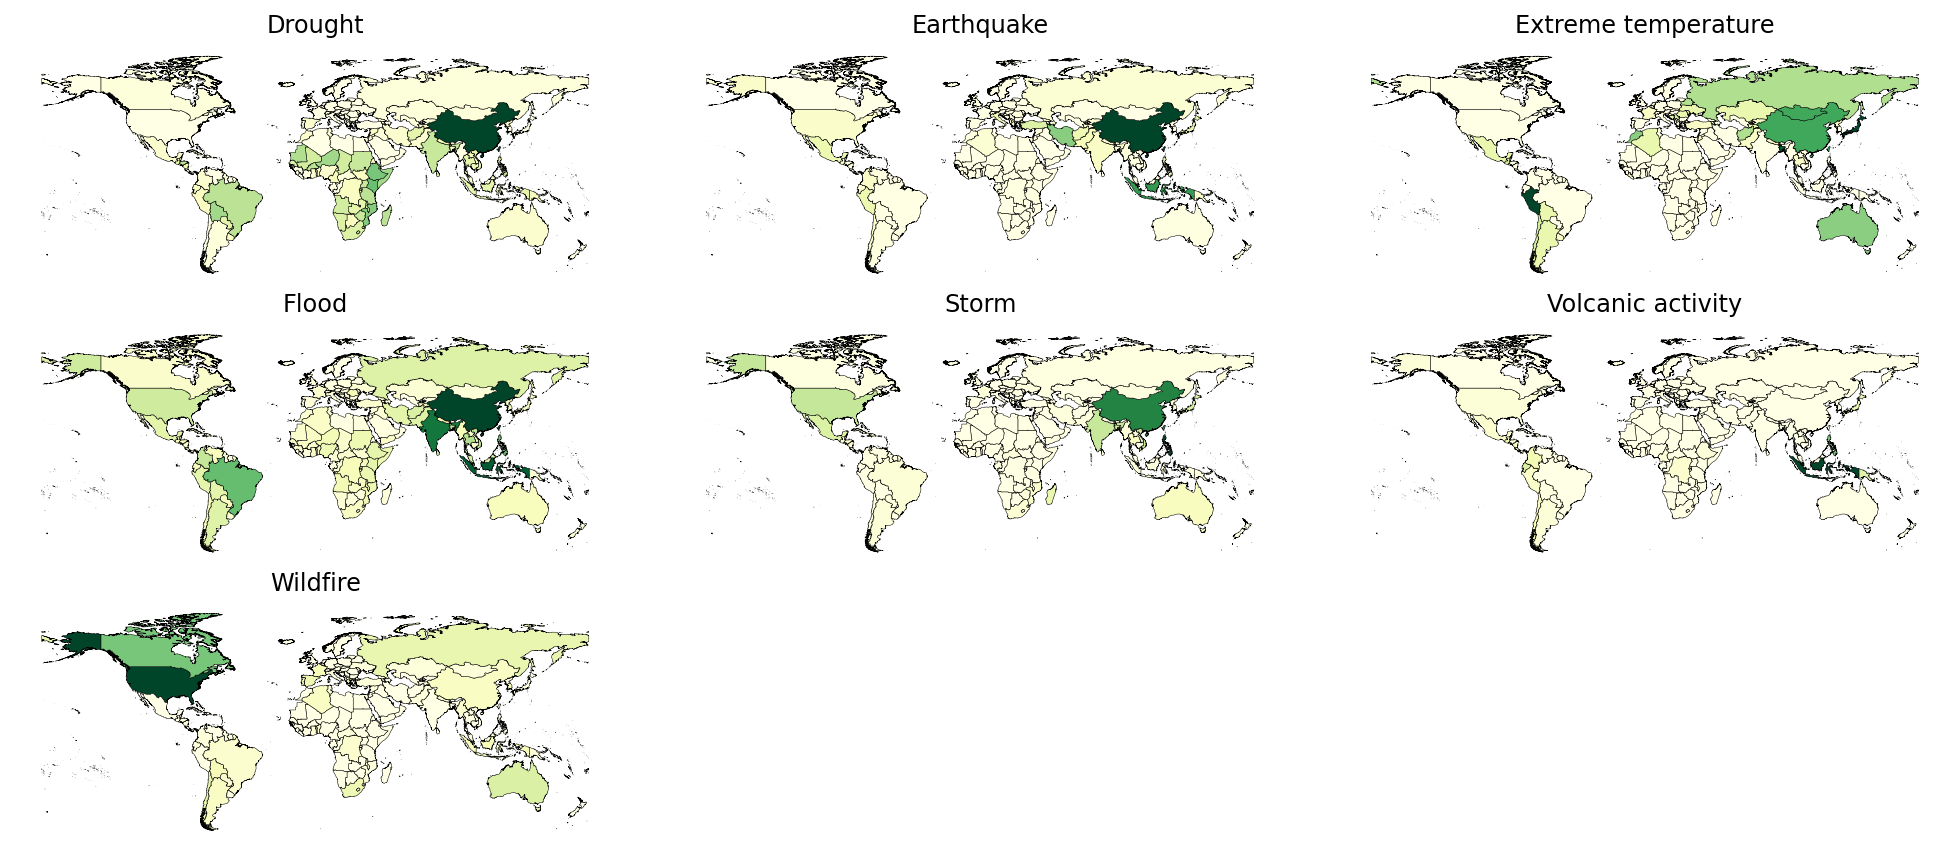

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):    
    if disaster is None:
        axis.set_visible(False)
        continue
        
    disaster_2000s = df_prob.loc['2000':, [disaster]].groupby(level=0).sum()
    disaster_2000s = (disaster_2000s - disaster_2000s.mean()) / disaster_2000s.std()
    pd.merge(world, disaster_2000s, left_index=True, right_index=True).plot(disaster, ax=axis, cmap='YlGn', edgecolor='k', lw=0.25)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Networks

In [10]:
with warnings.catch_warnings(action='ignore'):
    # Make graph of bordering countires
    w1 = fuzzy_contiguity(world)
    
    # Robustness of statistics to choice of k?
    w2 = KNN.from_dataframe(world, k=2)    
    w = w_union(w1, w2)
    keys = sorted(list(w.neighbors.keys()))
    
    G = w.to_networkx().to_undirected()
    
    # Discard all but the main connected component (largest connected subgraph)
    G = nx.subgraph(G, list(nx.connected_components(G))[0])
    
    # Make a dataset of only the regions in the resulting graph
    connected_world = world.iloc[list(G.nodes)].copy()
    idx_to_name = dict(enumerate(keys))
    
    # Change node names from numbers to ISO codes and do a sanity check
    G = nx.relabel_nodes(G, idx_to_name)
    assert list(G['USA'].keys()) == ['CAN', 'MEX']
    
    
    # Compute the weight matrix resulting from the graph and do a sanity check
    w = W.from_networkx(G)
    w.remap_ids(list(G.nodes))
    assert w.neighbors['USA'] == ['CAN', 'MEX']

In [11]:
#Creating the adjacency matrix
A = nx.adjacency_matrix(G)

In [12]:
# Compute node positions for network graph (spring layout)
pos = nx.drawing.nx_pydot.graphviz_layout(G, 'neato')

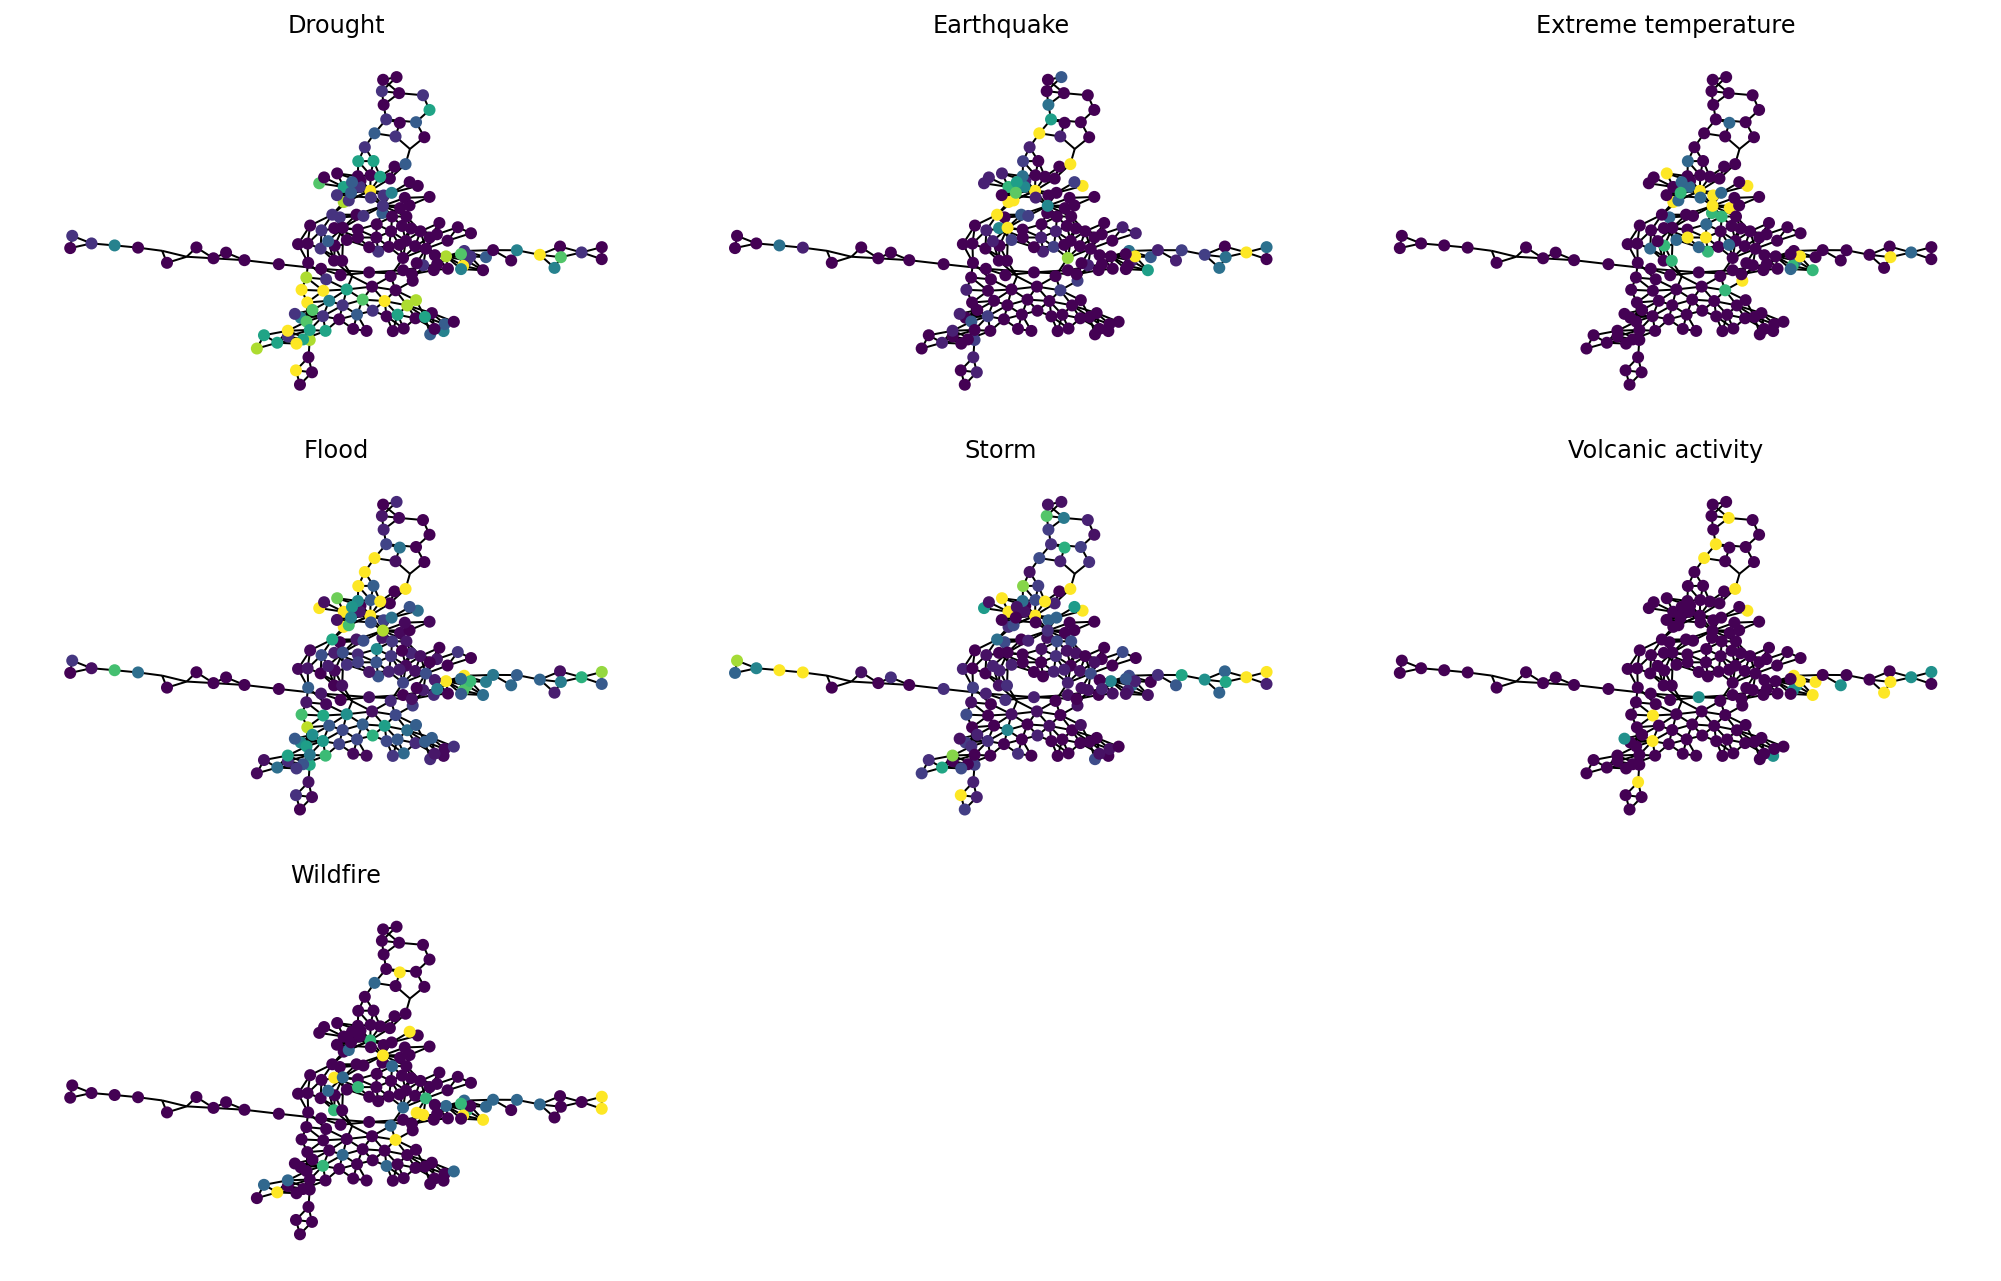

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(14, 9), dpi=144)

for axis, disaster in zip_longest(fig.axes, df_prob):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster]) 
    
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    node_dict = node_data.to_dict()
    vmin, vmax = node_data.quantile([0.05, 0.95])
    
    nx.draw_networkx_nodes(G, pos, node_size=25, node_color=[node_dict.get(n) for n in G.nodes],
                           ax=axis,
                           vmin=vmin, vmax=vmax)
    nx.draw_networkx_edges(G, pos, ax=axis)
    axis.set_title(disaster)
    axis.axis('off')
fig.tight_layout()
plt.show()

# Spatial Autocorrelation (Moran's I)

### Sum since 2000

In [14]:
def get_stars(p):
    if p < 0.01:
        return '***'
    if p < 0.05:
        return '**'
    if p < 0.1: 
        return '*'
    return ''

In [15]:
print(f'{"Disaster":<22}{"Moran I":>15}{"P-value":>15}')
print('-'*60)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    node_data = merged_df.loc[:, years[-25:]].sum(axis=1)
    node_data = (node_data - node_data.mean()) / node_data.std()
    mi = Moran(node_data, w)
    print(f'{disaster:<20} {mi.I:>15.3f}{get_stars(mi.p_norm)}{mi.p_norm:>15.3f}')

Disaster                      Moran I        P-value
------------------------------------------------------------
Drought                       -0.090          0.114
Earthquake                    -0.014          0.867
Extreme temperature           -0.078          0.174
Flood                         -0.028          0.667
Storm                          0.063          0.199
Volcanic activity             -0.008          0.957
Wildfire                      -0.002          0.948


### Year-by-year, full sample

In [16]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years)
for disaster in disasters:
    merged_df = connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
    for year in years:
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df[year], w)
            corr_df.loc[year, disaster] = mi.I

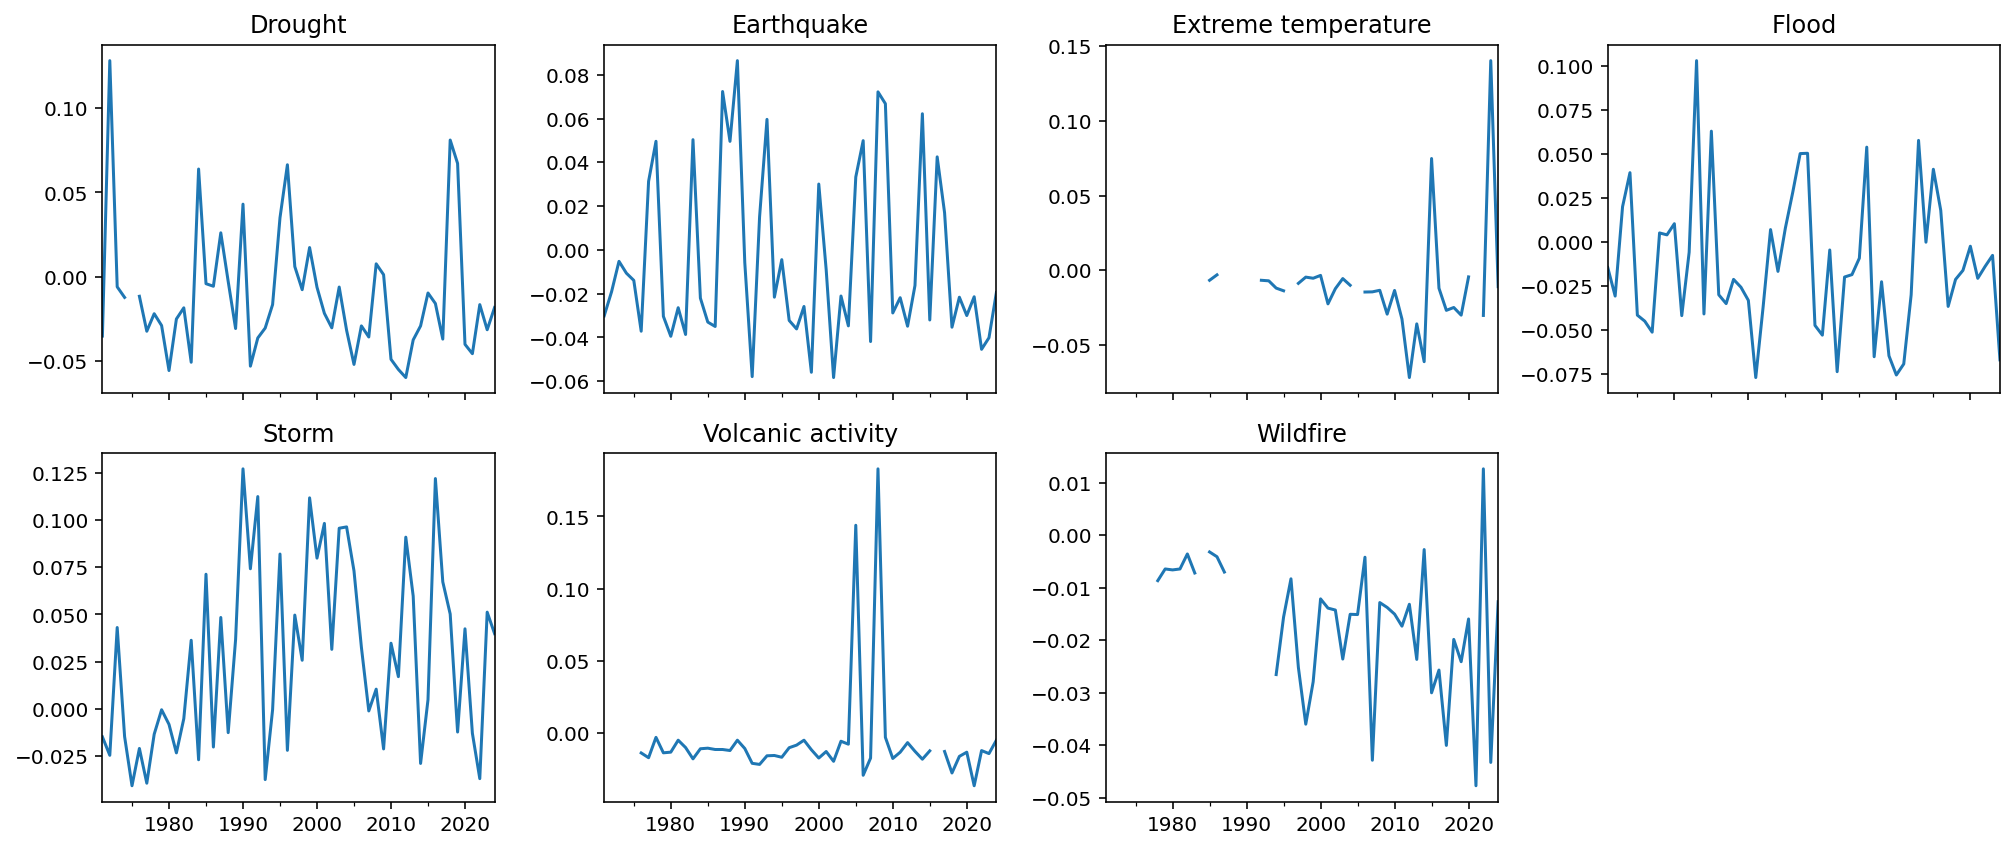

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144, sharex=True)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

## Rolling 10-year average

In [18]:
corr_df = pd.DataFrame(np.nan, columns=df_prob.columns, index=years[10:])
for disaster in disasters:
    merged_df = (connected_world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years]
                     .T)
    for start, stop in zip(years[:-10], years[10:]):
        with warnings.catch_warnings(action='ignore'):
            mi = Moran(merged_df.loc[start:stop].mean(), w)
            corr_df.loc[start, disaster] = mi.I

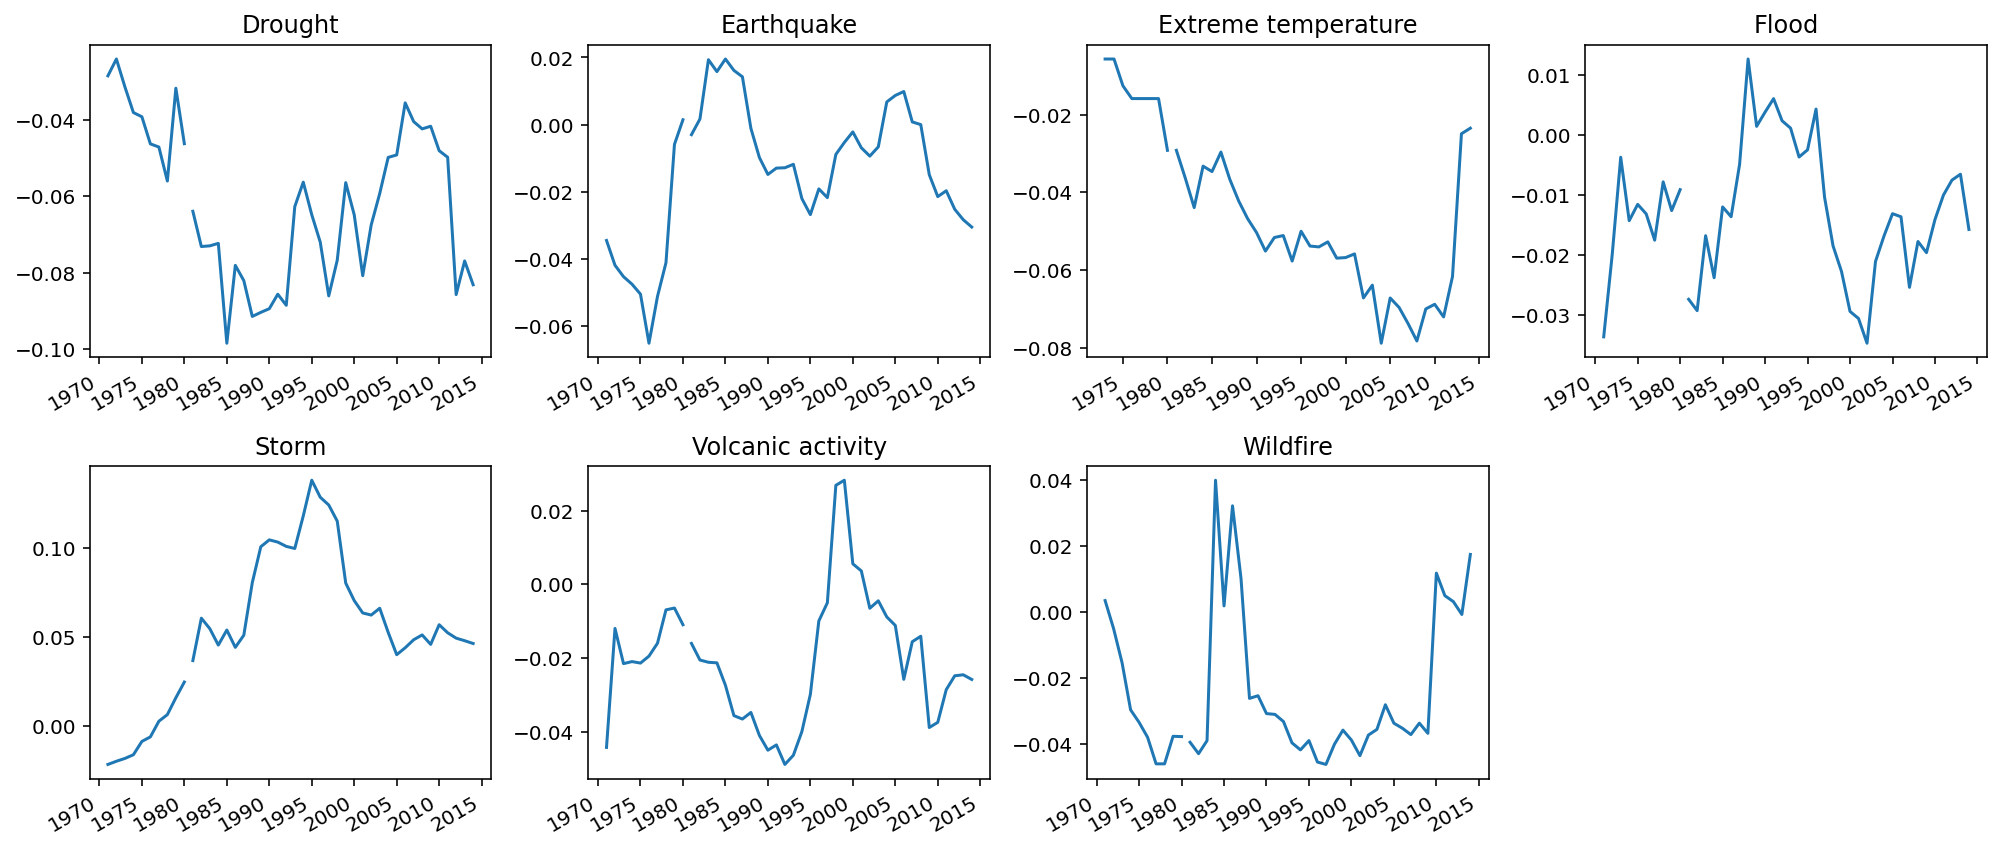

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    corr_df[disaster].plot(ax=axis)
    axis.set_title(disaster)
fig.tight_layout()
plt.show()

# Variograms

In [20]:
import skgstat as skg

In [21]:
centroids = (world.geometry
                 .to_crs('EPSG:3857')
                 .centroid
                 .apply(lambda x: pd.Series({'x':x.x, 'y':x.y}))
                 .mul(1e-3)) # convert meters to km

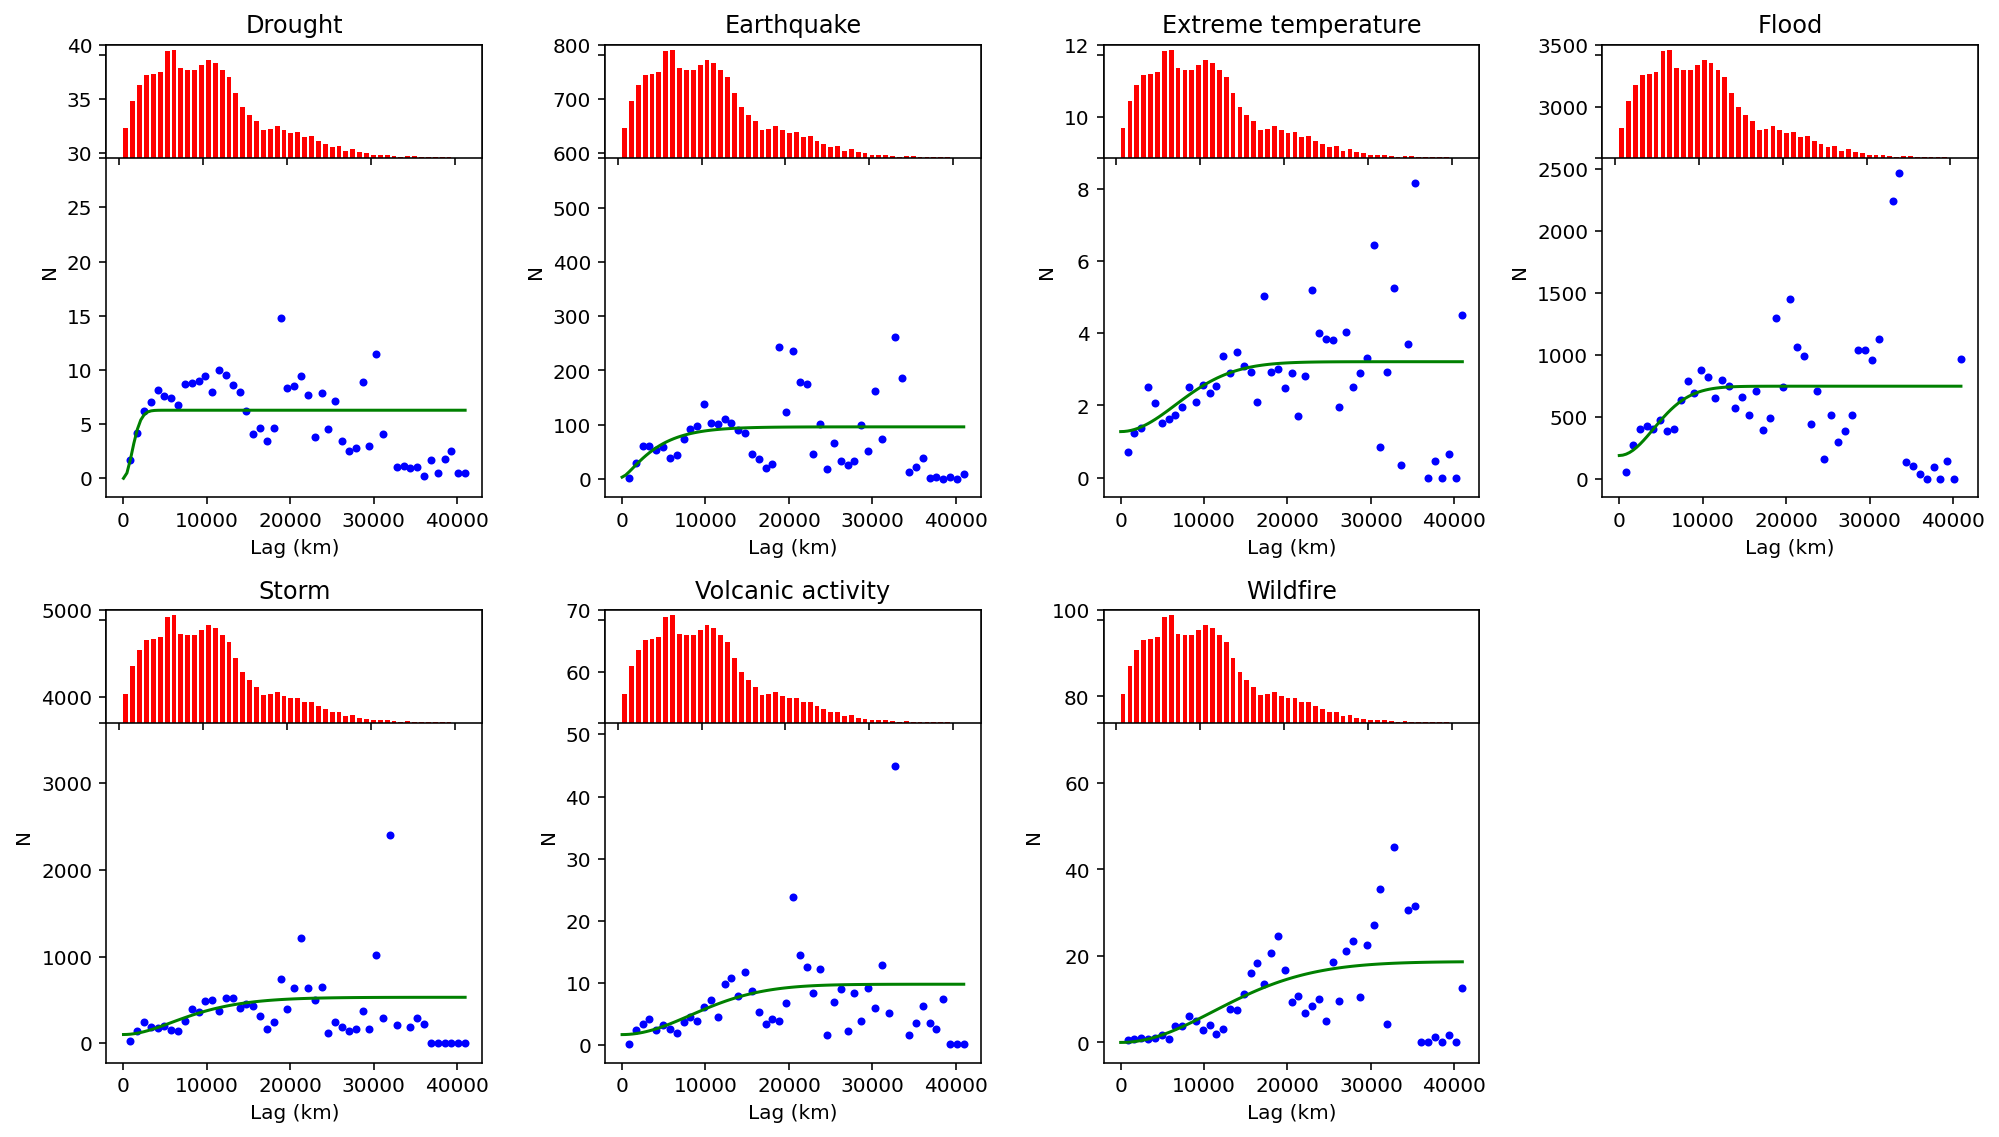

In [22]:
fig, ax = plt.subplots(2, 4, figsize=(14, 8), dpi=144)
for axis, disaster in zip_longest(fig.axes, disasters):
    if disaster is None:
        axis.set_visible(False)
        continue
    
    merged_df = (world.join(df_prob.unstack(1).fillna(0)[disaster])
                     .loc[:, years[-25:]]
                     .sum(axis=1))
    V = skg.Variogram(coordinates=centroids,
                      values=merged_df,
                      estimator='matheron',
                      dist_func='euclidean',
                      model='matern',
                      n_lags=50,
                      use_nugget=True)
    hist_ax = axis.inset_axes(bounds=[0, 0.75, 1.0, 0.25])
    V.plot(axes=[axis, hist_ax], show=False, grid=False)
    ticks = [x for x in hist_ax.xaxis.get_majorticklocs()]
    hist_ax.set_yticklabels([])
    hist_ax.set_xticklabels([])
    
    axis.set(title=disaster, xlabel = 'Lag (km)')
    axis.tick_params(axis='x', labelbottom=True)

    
fig.tight_layout()
plt.show()

# Models

In [23]:
#Defining the random seed for sampling
RANDOM_SEED = 8926
rng = np.random.default_rng(RANDOM_SEED)

In [24]:
#Scaling factor function
def scaling_factor_sp(A):
    """Compute the scaling factor from an adjacency matrix.
    This function uses sparse matrix computations and is most
    efficient on sparse adjacency matrices. Used in the BYM2 model.
    The scaling factor is a measure of the variance in the number of
    edges across nodes in a connected graph.
    Only works for fully connected graphs. The argument for scaling
    factors is developed by Andrea Riebler, Sigrunn H. Sørbye,
    Daniel Simpson, Havard Rue in "An intuitive Bayesian spatial
    model for disease mapping that accounts for scaling"
    https://arxiv.org/abs/1601.01180"""

    # Computes the precision matrix in sparse format
    # from an adjacency matrix.

    num_neighbors = A.sum(axis=1)
    A = sparse.csc_matrix(A)
    D = sparse.diags(num_neighbors, format="csc")
    Q = D - A

    # add a small jitter along the diagonal

    Q_perturbed = Q + sparse.diags(np.ones(Q.shape[0])) * max(Q.diagonal()) * np.sqrt(
        np.finfo(np.float64).eps
    )

    # Compute a version of the pseudo-inverse

    n = Q_perturbed.shape[0]
    b = sparse.identity(n, format="csc")
    Sigma = spsolve(Q_perturbed, b)
    A = np.ones(n)
    W = Sigma @ A.T
    Q_inv = Sigma - np.outer(W * solve(A @ W, np.ones(1)), W.T)

    # Compute the geometric mean of the diagonal on a
    # precision matrix.

    return np.exp(np.sum(np.log(np.diag(Q_inv))) / n)

In [25]:
#Defining the scaling factor
scaling_factor = scaling_factor_sp(A)
scaling_factor

1.0780858792524022

In [26]:
# Adjusting the shapes of coords and dara
df_prob = df_prob.drop(["ASM", "CYP", "EGY", "PLW", "PRI", "SXM"])

In [27]:
#New data structure
df_prob_spat = (df_prob
 .pivot_table(values= ['Drought', "Storm", "Flood"] , index = "ISO" , aggfunc= "sum" ))

In [28]:
#Defining coords
iso_idx, iso = pd.factorize(df_prob_spat.reset_index()['ISO'])
disaster_idx, disaster  =pd.factorize(df_prob_spat.columns.values)

coords = {"iso": iso, "disaster":disaster}

## Spatial only

In [29]:
with pm.Model(coords=coords) as spatial_model_d:
    # intercept
    beta0 = pm.Normal("beta0", mu =0, sigma = 1, dims = "disaster")

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims = ["iso", "disaster"])

    # spatially structured random effect
    spatial_effects = []
    for dis in disaster:
        phi = pm.ICAR(f"phi_{dis}", W = A.todense())
        spatial_effects.append(phi)
    phi = pm.Deterministic('phi', pt.stack(spatial_effects).T, dims=['iso', 'disaster'])

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1, dims =  "disaster")
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5, dims = "disaster")

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) *  phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0[None] + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_spat, dims = ["iso", "disaster"] )

In [30]:
#Sampling the model
with spatial_model_d:
    idata_spatial_model_d = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

In [31]:
az.summary(idata_spatial_model_d, var_names=["beta0", "sigma", "rho"] )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0[Drought] -0.035  0.167  -0.338    0.286      0.005    0.004    1149.0   
beta0[Flood]    1.957  0.132   1.714    2.216      0.008    0.006     263.0   
beta0[Storm]    0.877  0.139   0.610    1.131      0.006    0.004     545.0   
sigma[Drought]  1.595  0.148   1.324    1.869      0.006    0.004     611.0   
sigma[Flood]    1.625  0.106   1.432    1.824      0.006    0.004     322.0   
sigma[Storm]    1.609  0.115   1.383    1.816      0.007    0.005     296.0   
rho[Drought]    0.042  0.048   0.000    0.129      0.003    0.002     157.0   
rho[Flood]      0.031  0.036   0.000    0.093      0.005    0.004      31.0   
rho[Storm]      0.037  0.042   0.000    0.114      0.004    0.003      77.0   

                ess_tail  r_hat  
beta0[Drought]    1891.0   1.01  
beta0[Flood]       557.0   1.04  
beta0[Storm]      1274.0   1.01  
sigma[Drought]    1500.0   1.01  
sigma[Flood]       821.0   1.03  
sigma[Storm]       660.0   1.02  
rho[Drought]       494.0   1.04  
rho[Flood]          65.0   1.19  
rho[Storm]         299.0   1.08

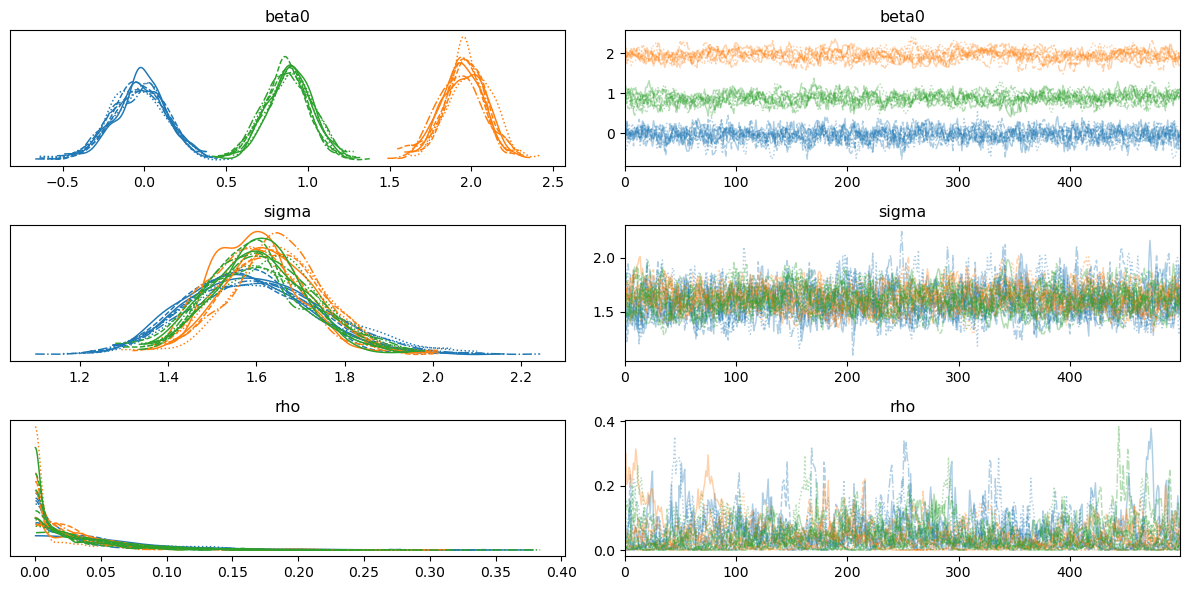

In [32]:
az.plot_trace(idata_spatial_model_d, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

### Drought network

In [33]:
phi_pred_d = idata_spatial_model_d.posterior.phi_Drought.mean(("chain", "draw")).values
beta0_pred_d = idata_spatial_model_d.posterior.beta0.mean(("chain", "draw"))[0].values
sigma_pred_d = idata_spatial_model_d.posterior.sigma.mean(("chain", "draw"))[0].values
y_predict_d = np.exp( beta0_pred_d[None] + sigma_pred_d * (1 / scaling_factor) * phi_pred_d)

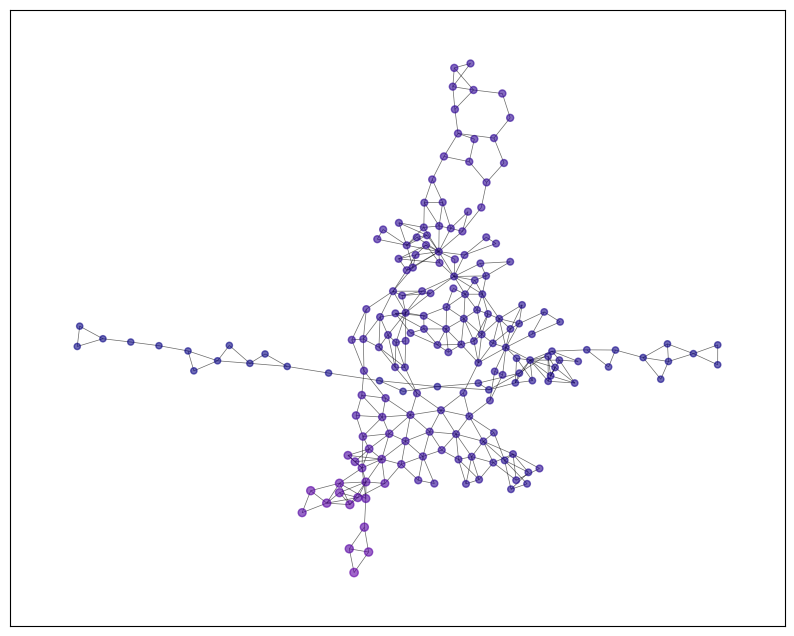

In [34]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict_d,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict_d,
)

### Flood network

In [35]:
phi_pred_f = idata_spatial_model_d.posterior.phi_Flood.mean(("chain", "draw")).values
beta0_pred_f = idata_spatial_model_d.posterior.beta0.mean(("chain", "draw"))[1].values
sigma_pred_f = idata_spatial_model_d.posterior.sigma.mean(("chain", "draw"))[1].values
y_predict_f = np.exp( beta0_pred_f[None] + sigma_pred_f * (1 / scaling_factor) * phi_pred_f)

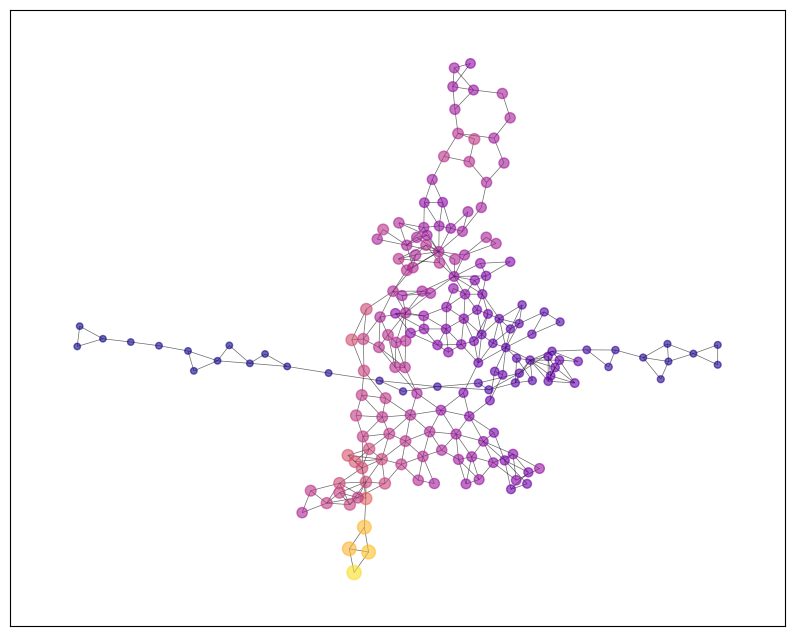

In [36]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict_f,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict_f,
)

### Storm network        

In [37]:
phi_pred_s = idata_spatial_model_d.posterior.phi_Storm.mean(("chain", "draw")).values
beta0_pred_s = idata_spatial_model_d.posterior.beta0.mean(("chain", "draw"))[2].values
sigma_pred_s = idata_spatial_model_d.posterior.sigma.mean(("chain", "draw"))[2].values
y_predict_s = np.exp( beta0_pred_s[None] + sigma_pred_s * (1 / scaling_factor) * phi_pred_s)

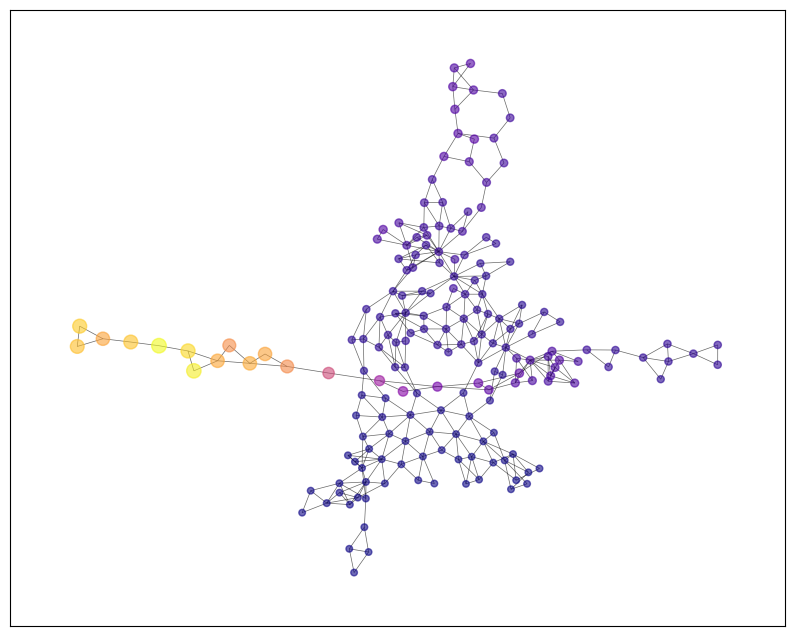

In [38]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict_s,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict_s,
)

## Spatial_region model

In [39]:
#Adding region and subregion columns
regions = (data["df_prob_filtered_adjusted"].pivot_table(values= ['Drought'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
 .reset_index().set_index(["ISO"])
 .drop(["Drought"], axis = 1)
    )

df_prob_reg =  pd.merge(df_prob, regions, left_index=True, right_index=True, how="left")

In [40]:
#Defining coords
iso_idx, iso = pd.factorize(df_prob_reg.reset_index()['ISO'])
region_idx, region = pd.factorize(df_prob_reg.pivot_table(values= ['Drought'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
                                  .reset_index().set_index(["ISO"])['Region'])
subregion_idx, subregion = pd.factorize(df_prob_reg.pivot_table(values= ['Drought'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
                                  .reset_index().set_index(["ISO"])['Subregion'])

coords = coords = {"iso": iso, "region": region, "subregion": subregion}

### Drought

First, we sum over time to work only with space dimension

In [41]:
df_prob_space_drought_region = (df_prob_reg.
                                pivot_table(values= ['Drought'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
                                .reset_index().set_index(["ISO"]))

In [42]:
with pm.Model(coords=coords) as spatial_model_region_d:
    # intercept 1
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # intercept 2
    beta1 = pm.ZeroSumNormal("beta1",  dims = "region" )

    # intercept
    beta2 = pm.ZeroSumNormal("beta2",  dims = "subregion" )

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + beta1[region_idx] + beta2[subregion_idx] + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_drought_region["Drought"])

In [43]:
#Sampling the model
with spatial_model_region_d:
    idata_spatial_model_region_d = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)
    pm.sample_posterior_predictive(idata_spatial_model_region_d, extend_inferencedata=True )

Sampling: [y_i]


Output()

In [44]:
az.summary(idata_spatial_model_region_d, var_names=["beta0", "beta1", "beta1", "sigma", "rho"] )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0           -0.491  0.207  -0.884   -0.098      0.004    0.003    2584.0   
beta1[Asia]      0.556  0.441  -0.289    1.368      0.009    0.007    2258.0   
beta1[Africa]    0.799  0.524  -0.212    1.776      0.013    0.009    1729.0   
beta1[Americas]  0.161  0.583  -0.994    1.206      0.012    0.009    2338.0   
beta1[Europe]   -1.362  0.504  -2.316   -0.455      0.008    0.006    3983.0   
beta1[Oceania]  -0.154  0.488  -1.058    0.783      0.009    0.007    3123.0   
sigma            1.158  0.124   0.932    1.383      0.003    0.002    1287.0   
rho              0.063  0.075   0.000    0.204      0.003    0.002     624.0   

                 ess_tail  r_hat  
beta0              2832.0   1.00  
beta1[Asia]        2405.0   1.00  
beta1[Africa]      1983.0   1.00  
beta1[Americas]    2364.0   1.00  
beta1[Europe]      3324.0   1.00  
beta1[Oceania]     3007.0   1.00  
sigma              2176.0   1.01  
rho                 975.0   1.01

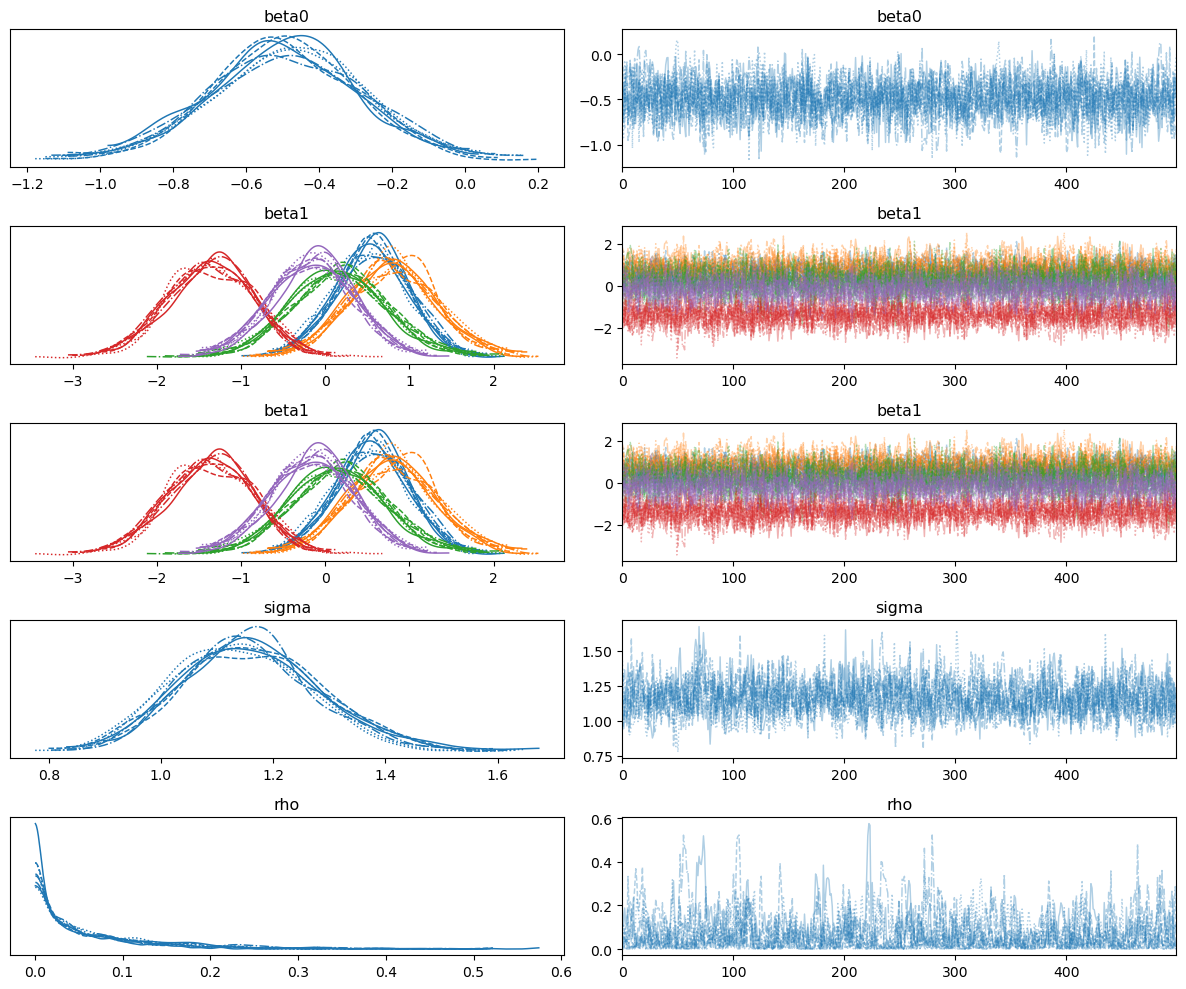

In [45]:
az.plot_trace(idata_spatial_model_region_d, var_names=["beta0", "beta1", "beta1", "sigma", "rho"])
plt.tight_layout();

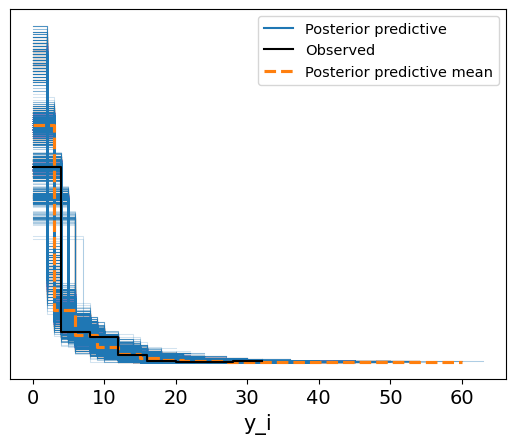

In [46]:
az.plot_ppc(idata_spatial_model_region_d );

In [47]:
phi_pred_region_d = idata_spatial_model_region_d.posterior.phi.mean(("chain", "draw")).values
beta0_predregion_d = idata_spatial_model_region_d.posterior.beta0.mean(("chain", "draw")).values
sigma_predregion_d = idata_spatial_model_region_d.posterior.sigma.mean(("chain", "draw")).values
y_predictregion_d = np.exp( beta0_predregion_d + sigma_predregion_d * (1 / scaling_factor) * phi_pred_region_d)

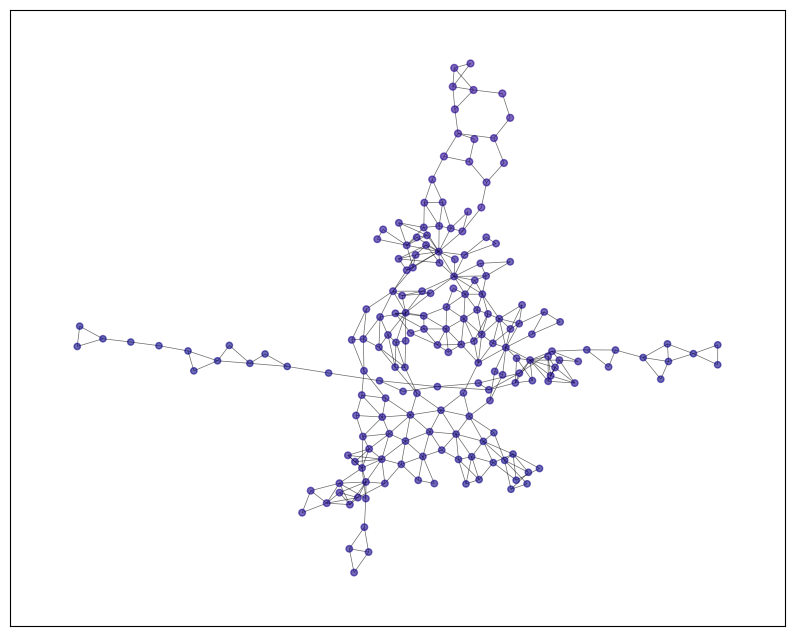

In [48]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predictregion_d,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predictregion_d,
)

### Flood

In [49]:
df_prob_space_flood_region = (df_prob_reg.
                                pivot_table(values= ['Flood'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
                                .reset_index().set_index(["ISO"]))

In [50]:
with pm.Model(coords=coords) as spatial_model_region_f:
    # intercept 1
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # intercept 2
    beta1 = pm.ZeroSumNormal("beta1",  dims = "region" )

    # intercept
    beta2 = pm.ZeroSumNormal("beta2",  dims = "subregion" )

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + beta1[region_idx] + beta2[subregion_idx] + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_flood_region["Flood"])

In [51]:
#Sampling the model
with spatial_model_region_f:
    idata_spatial_model_region_f = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

In [52]:
az.summary(idata_spatial_model_region_f, var_names=["beta0", "sigma", "rho"] )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  1.720  0.168   1.392    2.022      0.003    0.002    3049.0    3336.0   
sigma  1.316  0.097   1.149    1.512      0.003    0.002    1114.0    1885.0   
rho    0.056  0.062   0.000    0.169      0.004    0.003     384.0     463.0   

       r_hat  
beta0   1.00  
sigma   1.00  
rho     1.03

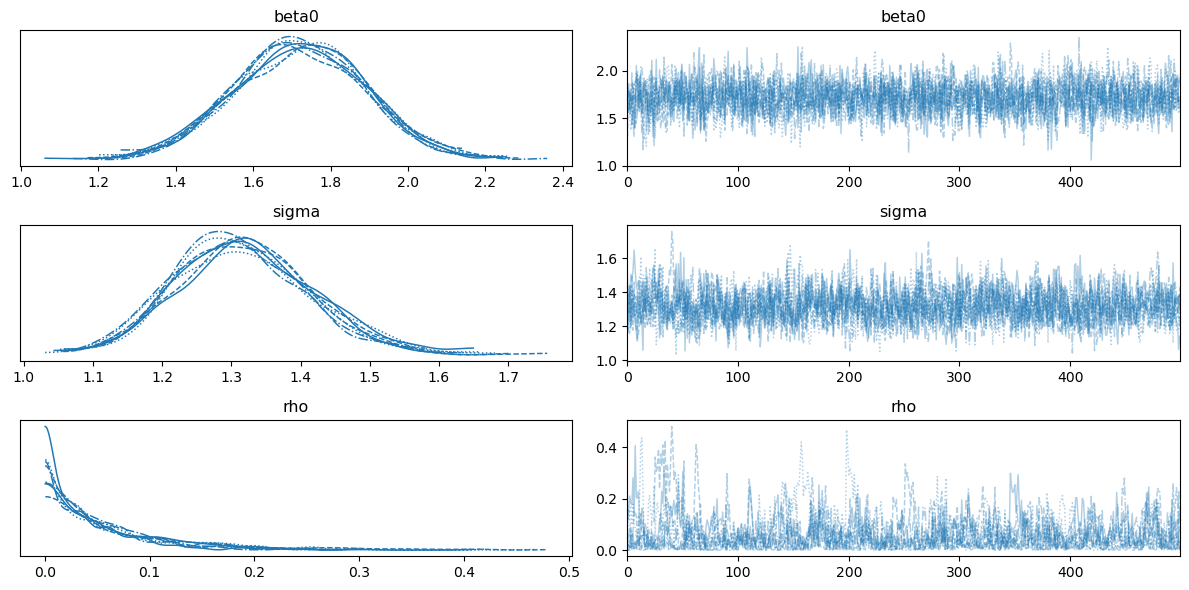

In [53]:
az.plot_trace(idata_spatial_model_region_f, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [54]:
phi_pred_region_f = idata_spatial_model_region_f.posterior.phi.mean(("chain", "draw")).values
beta0_pred_region_f = idata_spatial_model_region_f.posterior.beta0.mean(("chain", "draw")).values
sigma_pred_region_f = idata_spatial_model_region_f.posterior.sigma.mean(("chain", "draw")).values
y_predict_region_f = np.exp( beta0_pred_region_f + sigma_pred_region_f * (1 / scaling_factor) * phi_pred_region_f)

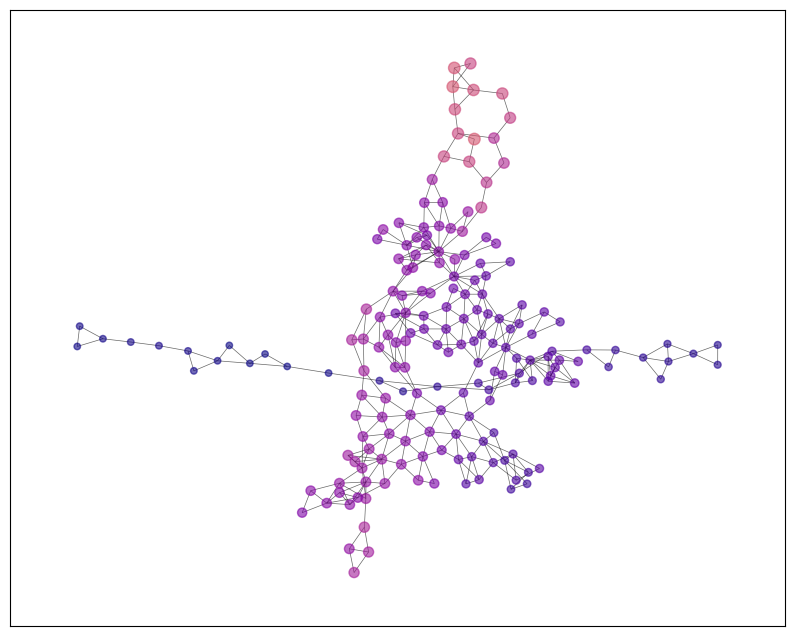

In [55]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict_region_f,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict_region_f,
)

### Storm

In [56]:
df_prob_space_storm_region = (df_prob_reg.
                                pivot_table(values= ['Storm'] , index = ["ISO", "Region", "Subregion"] , aggfunc= "sum" )
                                .reset_index().set_index(["ISO"]))

In [57]:
with pm.Model(coords=coords) as spatial_model_region_s:
    # intercept 1
    beta0 = pm.Normal("beta0", mu =0, sigma = 1)

    # intercept 2
    beta1 = pm.ZeroSumNormal("beta1",  dims = "region" )

    # intercept
    beta2 = pm.ZeroSumNormal("beta2",  dims = "subregion" )

    # independent random effect
    theta = pm.Normal("theta", mu = 0, sigma = 1, dims="iso")

    # spatially structured random effect
    phi = pm.ICAR("phi", W= A.todense())

    # joint variance of random effects
    sigma = pm.HalfNormal("sigma", 1)
    
    # the mixing rate is rho
    rho = pm.Beta("rho", 0.5, 0.5)

    # the bym component - it mixes a spatial and a random effect
    mixture = pt.sqrt(1 - rho) * theta + pt.sqrt(rho / scaling_factor) * phi

    # exponential link function to ensure
    # predictions are positive
    mu = pt.exp(beta0 + beta1[region_idx] + beta2[subregion_idx] + sigma * mixture)

    y_i = pm.Poisson("y_i", mu, observed=df_prob_space_storm_region["Storm"])

In [58]:
#Sampling the model
with spatial_model_region_s:
    idata_spatial_model_region_s = pm.sample(draws = 500,chains = 8,  nuts_sampler="nutpie", random_seed=rng)

In [59]:
az.summary(idata_spatial_model_region_s, var_names=["beta0", "sigma", "rho"] )

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0  0.957  0.169   0.657    1.288      0.003    0.002    3004.0    3026.0   
sigma  1.303  0.100   1.109    1.483      0.003    0.002    1566.0    2026.0   
rho    0.022  0.032   0.000    0.077      0.001    0.001     968.0    1075.0   

       r_hat  
beta0   1.00  
sigma   1.01  
rho     1.01

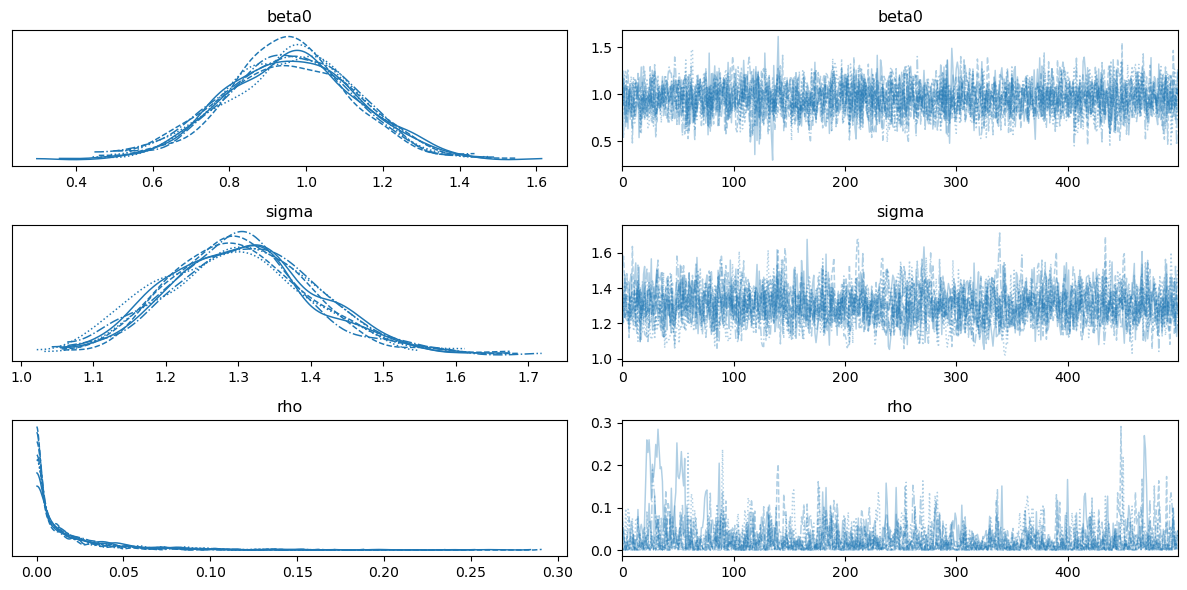

In [60]:
az.plot_trace(idata_spatial_model_region_s, var_names=["beta0", "sigma", "rho"])
plt.tight_layout();

In [61]:
phi_pred_region_s = idata_spatial_model_region_s.posterior.phi.mean(("chain", "draw")).values
beta0_pred_region_s  = idata_spatial_model_region_s.posterior.beta0.mean(("chain", "draw")).values
sigma_pred_region_s  = idata_spatial_model_region_s.posterior.sigma.mean(("chain", "draw")).values
y_predict_region_s  = np.exp( beta0_pred_region_s + sigma_pred_region_s * (1 / scaling_factor) * phi_pred_region_s)

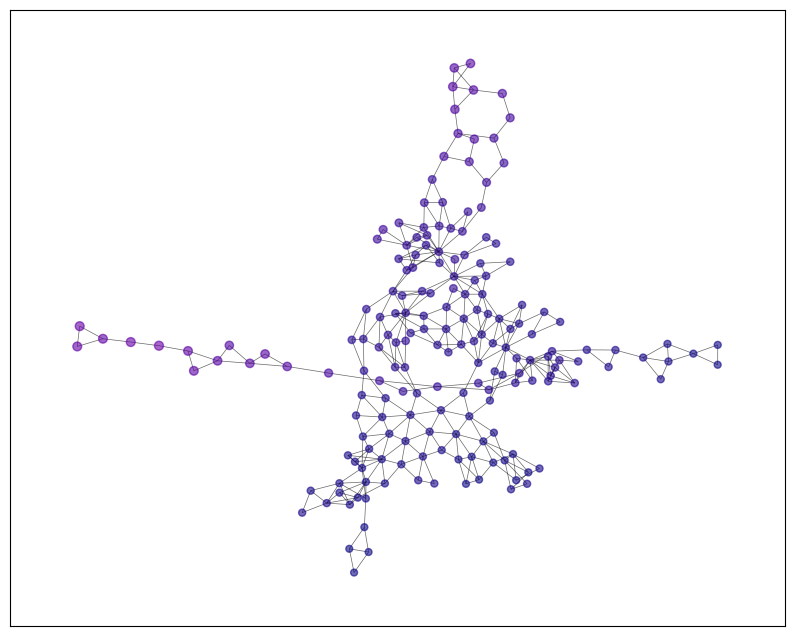

In [62]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(
    G,
    pos=pos,
    node_color=y_predict_region_s,
    cmap="plasma",
    vmax=30,
    width=0.5,
    alpha=0.6,
    with_labels=False,
    node_size=20 + 3 * y_predict_region_s,
)